In [1]:
import sys
import numpy as np

sys.path.insert(0, "..")

# Agents
from src.agents.robust_lin_exp3 import RobustLinExp3Agent

# Adversaries
from src.adversaries.adversary import Adversary
from src.adversaries.deceptive_adversary import DeceptiveAdversary

# Contexts
from src.contexts.context import Context
from src.contexts.gaussian_context import GaussianContext

# Environments
from src.environments.environment import Environment
from src.environments.adversarial_mab_env import Adversarial_MAB_env, Random_Adversarial_MAB_env
from src.environments.adversarial_contextual_env import AdversarialContextualEnv

# Adversarial Contextual MAB bandits
from src.adversarial_contextual_mab import AdversarialContextualMAB

# Display
from src.display.visualization import Visualization as vis

In [18]:
# Init vars
K = 10
h = 2
num_sim = 100
num_ctx = 5
num_ftrs = 3
lr = 0.1
exploration_rate = 0.1

# Init Adversary
adv = DeceptiveAdversary(K=K)

# Init Context
ctx = GaussianContext(n_contexts=num_ctx, n_arms=K, n_features=num_ftrs)

# Init Agent
sigma = ctx.estimate_sigma(n_samples=10000)
ag = RobustLinExp3Agent(name="RobustLinExp3", K=K, d=num_ftrs, sigma=sigma, eta=lr, gamma=exploration_rate)

# Init Environment
adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)

In [19]:
# Init Experiment
exp = AdversarialContextualMAB()
(rewards, 
 regrets, 
 avg_rewards, 
 pseudo_regrets, 
 cumulative_regrets, 
 cumulative_pseudo_regrets) = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)

In [20]:
bound_per_timestep = np.array([ag.compute_regret_bound(t) for t in range(h)])

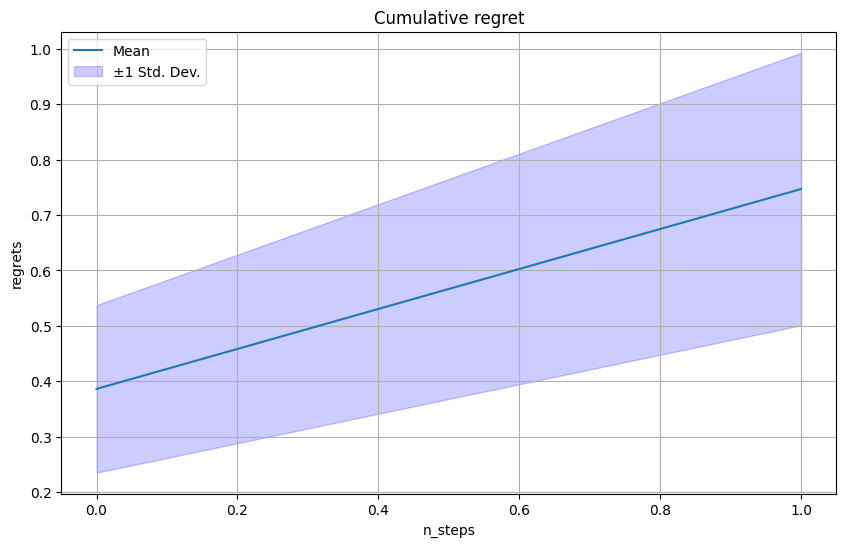

In [22]:
vis.plot_mean_std(
    data=cumulative_regrets, 
    title="Cumulative regret", 
    xlabel="n_steps", 
    ylabel="regrets", 
    # baseline= bound_per_timestep,
)